In [78]:
from __future__ import print_function
from __future__ import division
import cv2
import os  
import numpy as np             
import matplotlib.pyplot as plt                        
%matplotlib inline 

from os import listdir
from PIL import Image
from numpy import asarray

import math
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR
import time
from torch.nn import Parameter

import torch.optim as optim
import torchvision
from torchvision import models
from torch.autograd import Variable

import os

from tqdm import tqdm

import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0


In [82]:
# from ; https://github.com/timesler/facenet-pytorch/blob/master/models/inception_resnet_v1.py

class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes,
            kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False
        ) # verify bias false
        self.bn = nn.BatchNorm2d(
            out_planes,
            eps=0.001, # value found in tensorflow
            momentum=0.1, # default pytorch value
            affine=True
        )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 128, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(128, 128, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionResnetV1(nn.Module):
    """Inception Resnet V1 model with optional loading of pretrained weights.
    Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
    datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
    requested and cached in the torch cache. Subsequent instantiations use the cache rather than
    redownloading.
    Keyword Arguments:
        pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
            (default: {None})
        classify {bool} -- Whether the model should output classification probabilities or feature
            embeddings. (default: {False})
        num_classes {int} -- Number of output classes. If 'pretrained' is set and num_classes not
            equal to that used for the pretrained model, the final linear layer will be randomly
            initialized. (default: {None})
        dropout_prob {float} -- Dropout probability. (default: {0.6})
    """
    def __init__(self, dropout_prob=0.6, device=None):
        super().__init__()



        # Define layers
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
        )
        self.block8 = Block8(noReLU=True)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        
        #7layer
        self.last_linear = nn.Linear(1792, 512, bias=False)
        


        self.device = torch.device('cpu')
        if device is not None:
            self.device = device
            self.to(device)

    def forward(self, x):
        """Calculate embeddings or logits given a batch of input image tensors.
        Arguments:
            x {torch.tensor} -- Batch of image tensors representing faces.
        Returns:
            torch.tensor -- Batch of embedding vectors or multinomial logits.
        """
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        
        x = self.last_linear(x.view(x.shape[0], -1))
        
        return x


In [83]:
model = InceptionResnetV1()
model

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

# Algorithm 1 The Pseudo-code of ArcFace on MxNet
Input: Feature Scale s, Margin Parameter m in Eq. 3, Class Number n, Ground-Truth ID gt.
1. x = mx.symbol.L2Normalization (x, mode = ’instance’)
2. W = mx.symbol.L2Normalization (W, mode = ’instance’)
3. fc7 = mx.sym.FullyConnected (data = x, weight = W, no bias = True, num hidden = n)
4. original target logit = mx.sym.pick (fc7, gt, axis = 1)
5. theta = mx.sym.arccos (original target logit)
6. marginal target logit = mx.sym.cos (theta + m)
7. one hot = mx.sym.one hot (gt, depth = n, on value = 1.0, off value = 0.0)
8. fc7 = fc7 + mx.sym.broadcast mul (one hot, mx.sym.expand dims (marginal target logit - original target logit, 1))
9. fc7 = fc7 * s
Output: Class-wise affinity score f c7.





In [84]:
#from : https://github.com/cvqluu/Angular-Penalty-Softmax-Losses-Pytorch/blob/df32a07680bb4561637ff6de1f28712ee8e7fb4c/loss_functions.py

class ArcFaceLoss(nn.Module):

    def __init__(self, in_features, out_features, eps=1e-7, s=None, m=None):
        super(ArcFaceLoss, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.logits  = nn.Linear(in_features, out_features, bias=False)
        #Margin Parameter m 
        self.m = 0.5
        #Feature Scale s
        self.s =  64.0 
        self.eps = eps

    def forward(self, x, labels):
        for W in self.logits.parameters():
            W = F.normalize(W, p=2, dim=1)
        
        x = F.normalize(x, p=2, dim=1)
        wf = self.logits(x)
        l = torch.diagonal(wf.transpose(0, 1)[labels])
        theta = torch.clamp(l, -1.+self.eps, 1-self.eps)
        marginal_target_logit = torch.acos(theta + self.m)
        numerator = marginal_target_logit * self.s
        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        loss = -torch.mean(L)
        return loss ,  numerator
    
    

In [85]:
batch_size = 16  # batch size
input_shape = (3, 128, 128)
normalize = T.Normalize(mean=[0.5], std=[0.5])

In [86]:
trin_transforms = T.Compose([
                T.Resize(input_shape[1:]),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                normalize
            ])

train_data = ImageFolder("10-Celebrity-faces/train", transform= trin_transforms)

trainloader = DataLoader(train_data, batch_size= batch_size ,
                         shuffle=True, drop_last=True, num_workers=4)

test_transforms = T.Compose([
                T.Resize(input_shape[1:]),
                T.ToTensor(),
                normalize
            ])

test_data = ImageFolder("10-Celebrity-faces/test", transform= test_transforms)

testloader = DataLoader(test_data, batch_size= batch_size ,
                         shuffle=True, drop_last=True, num_workers=4)

In [87]:
dataloaders = {
    "train": trainloader,
    "test": testloader
}

In [88]:
def plot_image_grid(images, columns=8, ax=None, show=True):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))
    image_grid = make_grid(images.detach().cpu(), columns, normalize=True)
    ax.imshow(image_grid.permute(1, 2, 0), interpolation='nearest')
    ax.axis('off')
    if show:
        plt.show(ax.figure)
    return ax

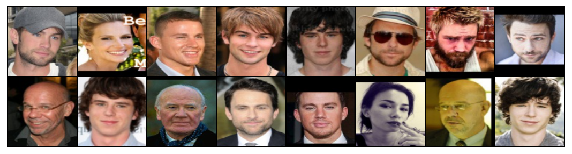

In [89]:
_ = plot_image_grid(next(iter(trainloader))[0])

In [90]:
num_classes = 10
metric ='ArcFaceLoss' 
max_epoch = 20
lr = 1e-1  # initial learning rate
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [91]:

criterion =  ArcFaceLoss(512, num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=lr_step, gamma=0.1)


In [93]:
def train(train_loader):
    model = InceptionResnetV1()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    total_step = len(train_loader)
    running_loss = 0
    for epoch in tqdm(range(max_epoch)): 
        for i, (feats, labels) in enumerate(tqdm(train_loader)):
            feats = feats.to(device)
            labels = labels.to(device)
            feature = model(feats)  
            loss , outputs = criterion(feature, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() 

        epoch_loss = running_loss / len(train_loader)
        print('{}: Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format("loss_type", epoch+1, max_epoch, i+1, total_step, epoch_loss))

        if((epoch+1) % 8 == 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr']/4
        
    return model.cpu()



In [94]:
model = train(dataloaders["train"])













  0%|          | 0/20 [00:00<?, ?it/s]












  0%|          | 0/41 [00:00<?, ?it/s]












  2%|▏         | 1/41 [00:03<02:39,  3.99s/it]Traceback (most recent call last):
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "//anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "//anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "//anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "//anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "//anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "//anaconda3/l

KeyboardInterrupt: 